In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score

from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append("/zhouxibin/workspaces/mutations")
from utils.rank import rank_strategy_dictionary
from utils.model import model_name_library
from utils.pipeline import read_sequence
from utils.metrics import read_dms_file

In [9]:
# compute random converage
dms_dir = "../data/dms"
sequence_dir = Path(dms_dir) / "fasta"
gt_dir = Path(dms_dir) / "dms"
results_dir = Path(dms_dir) / "results"

In [10]:
# get all sequence names
sequence_names = [g.stem for g in sequence_dir.glob("*.fa")]

## spearman

In [5]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(["regression_transformer"], rank_strategy_dictionary.keys()):
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            result_df = pd.read_csv(result_file)
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            # print(result_df.loc[:, ["fitness_pred", "fitness_dms"]].corr("spearman").iloc[0, 1])
            spearman_score = result_df.loc[:, ["fitness_pred", "fitness_dms"]].corr("spearman").iloc[0, 1]
            results_list.append((sequence_name, model_name, rank_strategy, spearman_score, wt_fitness))
results_spearman_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "spearman", "wt_fitness"])
results_spearman_df.head()

100%|██████████| 542/542 [00:06<00:00, 77.77it/s]


,sequence_name,model_name,rank_strategy,spearman,wt_fitness
0,2BTH.pdb,regression_transformer,esm1v_1,0.256190,2.730572
1,2J6K.pdb_pross9,regression_transformer,esm1v_1,0.080852,2.928706
2,5UBS.pdb,regression_transformer,esm1v_1,0.042641,3.252930
3,EEHEE_rd4_0570.pdb,regression_transformer,esm1v_1,0.098873,3.306471
4,EHEE_rd2_0191.pdb,regression_transformer,esm1v_1,0.257485,2.211911


In [7]:
results_spearman_df.to_csv("./8_data/regression_transformer_results_spearman_df.csv")


In [51]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    count = 0
    for model_name, rank_strategy in product(["regression_transformer"], rank_strategy_dictionary.keys()):
        if rank_strategy == "AR_5":
            continue
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            try:
                result_df = pd.read_csv(result_file)
            except:
                print(result_file)
                with open(result_file, "r") as f:
                    print(f.read())
                break
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            fpr, tpr, threshold = roc_curve(result_df["label"], result_df["fitness_pred"], drop_intermediate=False)
            auc_score = auc(fpr, tpr)
            results_list.append((sequence_name, model_name, rank_strategy, fpr, tpr, threshold, auc_score, wt_fitness))

results_auc_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "fpr", "tpr", "threshold", "auc_score", "wt_fitness"])
results_auc_df.head()

  0%|          | 0/542 [00:00<?, ?it/s]

100%|██████████| 542/542 [01:48<00:00,  5.01it/s]


,sequence_name,model_name,rank_strategy,fpr,tpr,threshold,auc_score,wt_fitness
0,2BTH.pdb,regression_transformer,esm1v_1,"[0.0, 0.012903225806451613, 0.0279569892473118...","[0.0, 0.01775147928994083, 0.02071005917159763...","[2.465, 1.465, 1.19, 1.135, 1.08, 1.025, 0.915...",0.613444,2.730572
1,2J6K.pdb_pross9,regression_transformer,esm1v_1,"[0.0, 0.0032102728731942215, 0.035313001605136...","[0.0, 0.0025, 0.02, 0.02, 0.0275, 0.0275, 0.03...","[1.145, 0.145, 0.09, -0.185, -0.24, -0.295, -0...",0.531607,2.928706
2,5UBS.pdb,regression_transformer,esm1v_1,"[0.0, 0.5603557814485387, 0.7674714104193139, ...","[0.0, 0.5342960288808665, 0.8194945848375451, ...","[1.145, 0.145, 0.09, 0.035, -0.02, -0.13, -0.1...",0.498342,3.252930
3,EEHEE_rd4_0570.pdb,regression_transformer,esm1v_1,"[0.0, 0.0070921985815602835, 0.009929078014184...","[0.0, 0.0, 0.0, 0.0, 0.09523809523809523, 0.12...","[2.795, 1.795, 1.74, 1.6795, 1.63, 1.5145, 1.4...",0.500128,3.306471
4,EHEE_rd2_0191.pdb,regression_transformer,esm1v_1,"[0.0, 0.028286189683860232, 0.0415973377703826...","[0.0, 0.02857142857142857, 0.07142857142857142...","[3.345, 2.345, 1.85, 1.795, 1.74, 1.685, 1.63,...",0.523140,2.211911


In [52]:
results_auc_df.to_csv("./8_data/regression_transformer_results_auc_df.csv")

In [11]:
from itertools import product
from tqdm import tqdm
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(["regression_transformer"], rank_strategy_dictionary.keys()):
        if rank_strategy == "AR_5":
            continue
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            try:
                result_df = pd.read_csv(result_file)
            except:
                print(result_file)
                with open(result_file, "r") as f:
                    print(f.read())
                # break
                continue
            # print(result_df.head())
            # print(dms_df.head())
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            # selected_number = 50
            # top selected_number set to 1, others set to 0
            result_df["label"] = result_df["fitness"] > 0
            result_df["label"][:selected_number] = 1
            result_df["label"][selected_number:] = 0
            result_df["label"] = result_df["label"].astype(bool)
            # print(result_df["label"].sum(), selected_number)
            # selected_rate = selected_number / result_df.shape[1]
            dms_df["label"] = dms_df["fitness"] > wt_fitness
            result_df = result_df.merge(dms_df, on="sequence", suffixes=("_pred", "_dms"))
            # print(result_df.head())
            # print(result_df.shape)
            # print(result_df["fitness_pred"]>0)
            # print(result_df["label"])
            precision = precision_score(result_df["label_dms"], result_df["label_pred"])
            results_list.append((sequence_name, model_name, rank_strategy, precision))
results_precision_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "precision"])
results_precision_df.head()

100%|██████████| 542/542 [00:05<00:00, 92.56it/s] 


,sequence_name,model_name,rank_strategy,precision
0,2BTH.pdb,regression_transformer,esm1v_1,0.420922
1,2J6K.pdb_pross9,regression_transformer,esm1v_1,0.333333
2,5UBS.pdb,regression_transformer,esm1v_1,0.259783
3,EEHEE_rd4_0570.pdb,regression_transformer,esm1v_1,0.130273
4,EHEE_rd2_0191.pdb,regression_transformer,esm1v_1,0.190736


In [12]:
results_precision_df.to_csv("./8_data/regression_transformer_results_precision_df.csv")


In [2]:
results_auc_df_rt = pd.read_csv("./8_data/regression_transformer_results_auc_df.csv")
results_auc_df_finetune = pd.read_csv("./6_data/results_auc_df_esm2_t12_35M_UR50D_glycosylase.csv")
# aggregate results_auc_df_fintune by the best auc
# results_auc_df_finetune = results_auc_df_finetune.groupby(["model_name", "rank_strategy"])["auc_score"].mean()
results_auc_df_finetune = results_auc_df_finetune[results_auc_df_finetune["rank_strategy"] == "esm1v_5"]
# results_auc_df_finetune.iloc[results_auc_df_finetune["auc_score"].argmax(), :]
results_auc_df = pd.read_csv("./5_data/results_auc_df.csv")
results_auc_df_650M = results_auc_df[(results_auc_df["model_name"] == "esm2_t33_650M_UR50D") & (results_auc_df["rank_strategy"] == "esm1v_5")]
results_auc_df_35M = results_auc_df[(results_auc_df["model_name"] == "esm2_t12_35M_UR50D") & (results_auc_df["rank_strategy"] == "esm1v_5")]
results_auc_df_concat = pd.concat([results_auc_df_650M, results_auc_df_35M, results_auc_df_finetune, results_auc_df_rt])


In [3]:
results_auc_df_concat["model_name"].unique()

array(['esm2_t33_650M_UR50D', 'esm2_t12_35M_UR50D',
       'esm2_t12_35M_UR50D_glycosylase', 'regression_transformer'],
      dtype=object)

In [19]:
# sequence_name = "2MKX.pdb"
# sequence_name = "1W4E.pdb"
# sequence_name = "2BTH.pdb"

# sequence_name = "HHH_rd1_0197.pdb"
sequence_name = "HHH_rd4_0557.pdb"
# sequence_name = "EHEE_rd2_0487.pdb"
auc_df_plot = results_auc_df_concat[results_auc_df_concat["sequence_name"] == sequence_name]


In [20]:
def from_str_get_list(x):
    x = x[1:-1]
    x = x.split(" ")
    return [float(i.strip()) for i in x if i != ""]

names = auc_df_plot["model_name"].values
fprs = [from_str_get_list(i) for i in auc_df_plot["fpr"].values]
tprs = [from_str_get_list(i) for i in auc_df_plot["tpr"].values]
thresholds = [from_str_get_list(i) for i in auc_df_plot["threshold"].values]

246 246 esm2_t33_650M_UR50D
265 265 esm2_t12_35M_UR50D
330 330 esm2_t12_35M_UR50D_glycosylase
13 13 regression_transformer


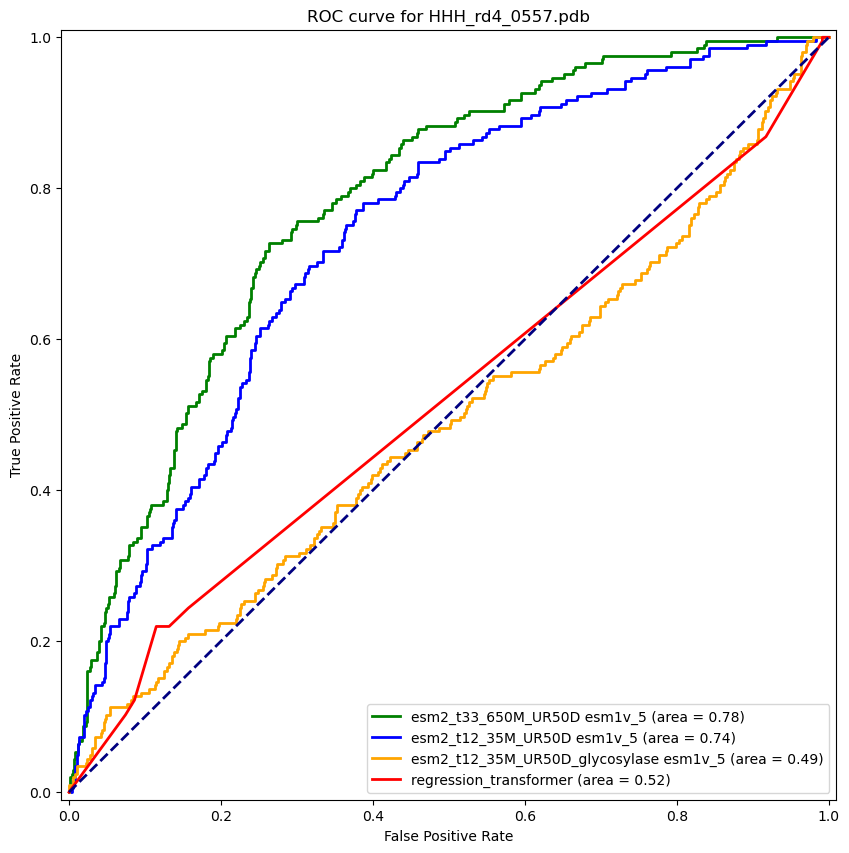

In [21]:
# plot ROC
plt.figure(figsize=(10, 10))
color_map = {
    "esm2_t33_650M_UR50D": "g",
    "esm2_t12_35M_UR50D": "b",
    "esm2_t12_35M_UR50D_glycosylase": "orange",
    "regression_transformer": "r"
}
lw = 2
for best_fpr, best_tpr, name in zip(fprs, tprs, names):
    print(len(best_fpr), len(best_tpr), name)
    plt.plot(best_fpr, best_tpr, lw=lw, label=f"{name} esm1v_5 (area = {auc(best_fpr, best_tpr):.2f})" if name != "regression_transformer" else f"{name} (area = {auc(best_fpr, best_tpr):.2f})", color=color_map[name])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC curve for {sequence_name}")
plt.legend(loc="lower right")
# plt.show()
plt.savefig(f"./8_data/ROC_{sequence_name}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"./8_data/ROC_{sequence_name}.tiff", dpi=300, bbox_inches='tight')

In [6]:
results_prcurve_df = pd.read_csv("./5_data/results_prcurve_df.csv")


In [7]:
def from_str_get_list(x):
    x = x[1:-1]
    x = x.split(" ")
    return [float(i.strip()) for i in x if i != ""]

# names = auc_df_plot["model_name"].values
# fprs = [from_str_get_list(i) for i in auc_df_plot["fpr"].values]
# tprs = [from_str_get_list(i) for i in auc_df_plot["tpr"].values]
# thresholds = [from_str_get_list(i) for i in auc_df_plot["threshold"].values]

In [10]:

test = results_prcurve_df[(results_prcurve_df["model_name"] == "esm2_t33_650M_UR50D") & (results_prcurve_df["rank_strategy"] == "esm1v_5")].sort_values("ap_score", ascending=False).iloc[0, :]
test

Unnamed: 0                                                     78125
sequence_name                                               2MKX.pdb
model_name                                       esm2_t33_650M_UR50D
rank_strategy                                                esm1v_5
precision          [0.40271493 0.40317101 0.40362812 0.40408627 0...
recall             [1.         1.         1.         1.         1...
threshold          [-16.69288063 -16.52787781 -16.40786362 -16.35...
ap_score                                                    0.814197
wt_fitness                                                  5.319625
random_ap_score                                             0.402715
Name: 78125, dtype: object

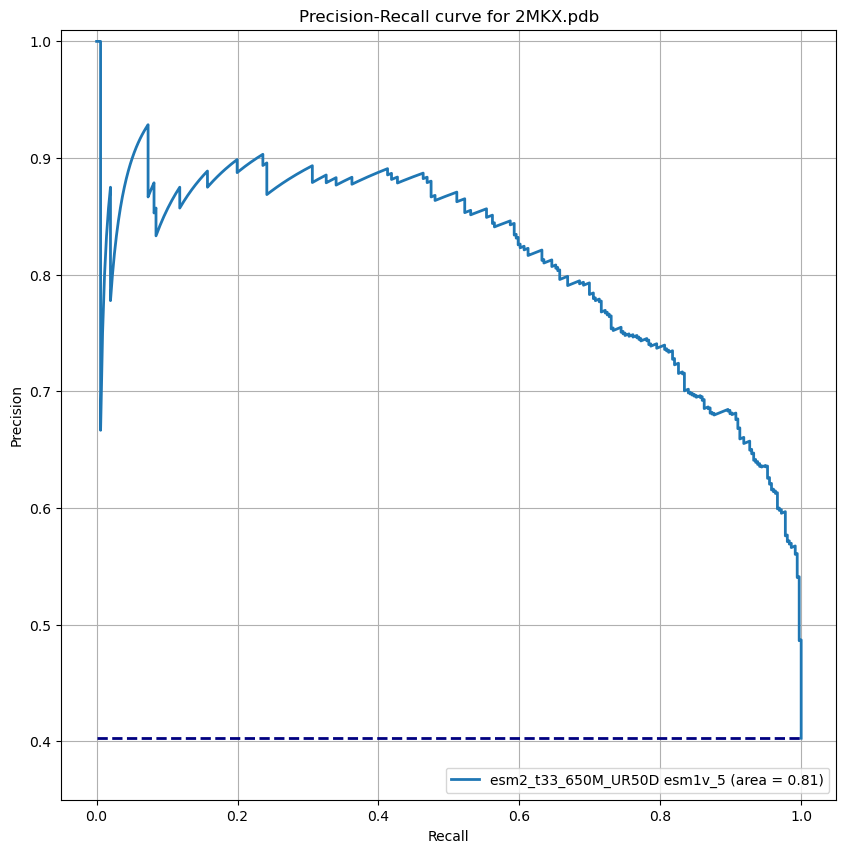

In [14]:
sequence_name = test["sequence_name"]
random_ap_score = test["random_ap_score"]
lw = 2
plt.figure(figsize=(10, 10))
# print(len(from_str_get_list(test["recall"])), len(from_str_get_list(test["precision"])))
plt.plot(from_str_get_list(test["recall"]), from_str_get_list(test["precision"]), lw=lw, label=f"{test['model_name']} {test['rank_strategy']} (area = {test['ap_score']:.2f})")
# draw random line
plt.plot([0, 1], [random_ap_score, random_ap_score], color='navy', lw=lw, linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.ylim([0.35, 1.01])
plt.grid()
plt.title(f"Precision-Recall curve for {sequence_name}")
plt.savefig(f"./8_data/PR_{sequence_name}.png", dpi=600, bbox_inches='tight')
plt.savefig(f"./8_data/PR_{sequence_name}.tiff", dpi=600, bbox_inches='tight')
plt.savefig(f"./8_data/PR_{sequence_name}.pdf", dpi=600, bbox_inches='tight')